<a href="https://colab.research.google.com/github/ariefbros/BISA-AI-Competition/blob/master/DCNNBisaAI.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow import keras 
import os
%matplotlib inline
from matplotlib import pyplot as plt
import cv2
import random


In [0]:
file_list = []
class_list = []

DATASET = '/content/drive/My Drive/DATASET/BISA-AI'

In [0]:
CATEGORIES = ["covid19","normal"]

IMG_SIZE = 224

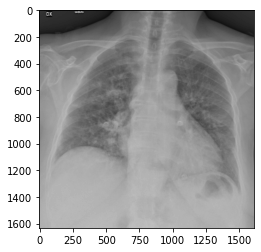

In [7]:
for category in CATEGORIES:  
    path = os.path.join(DATASET,category)  # create path to KATEGORI
    for img in os.listdir(path):  # iterate over each image per KATEGORI
        img_array = cv2.imread(os.path.join(path,img) ,cv2.IMREAD_GRAYSCALE)  # convert to array
        plt.imshow(img_array, cmap='gray')  # graph it
        plt.show()  # display!

        break  # we just want one for now so break
    break  #...and one more!

membuat training data

In [0]:
training_data = []
def create_training_data():
	for category in CATEGORIES :
		path = os.path.join(DATASET, category)
		class_num = CATEGORIES.index(category)
		for img in os.listdir(path):
			try :
				img_array= cv2.imread(os.path.join(path, img))
				new_array = cv2.resize(img_array, (IMG_SIZE, IMG_SIZE))
				training_data.append([new_array, class_num])
			except Exception as e:
				pass

create_training_data()
random.shuffle(training_data)

In [0]:
x_train = [] #features
y_train = [] #labels

for features, label in training_data:
	x_train.append(features)
	y_train.append(label)

x_train = np.array(x_train).reshape(-1, IMG_SIZE, IMG_SIZE, 3)

In [10]:
x_train.shape

(463, 224, 224, 3)

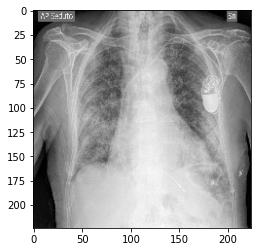

In [11]:
plt.imshow(keras.preprocessing.image.array_to_img(x_train[0]))

In [0]:
from sklearn.model_selection import train_test_split
xtrain, xtest, ytrain, ytest = train_test_split(x_train, y_train, test_size = 0.3)

In [13]:
from keras.utils import np_utils
ytrain = np_utils.to_categorical(ytrain, num_classes = 2)
ytest = np_utils.to_categorical(ytest, num_classes = 2)

Using TensorFlow backend.


In [14]:
print(f'SHAPE OF TRAINING IMAGE DATA : {xtrain.shape}')
print(f'SHAPE OF TESTING IMAGE DATA : {xtest.shape}')
print(f'SHAPE OF TRAINING LABELS : {ytrain.shape}')
print(f'SHAPE OF TESTING LABELS : {ytest.shape}')

SHAPE OF TRAINING IMAGE DATA : (324, 224, 224, 3)
SHAPE OF TESTING IMAGE DATA : (139, 224, 224, 3)
SHAPE OF TRAINING LABELS : (324, 2)
SHAPE OF TESTING LABELS : (139, 2)


# Implementing Transfer Learning ResNet50

In [0]:
from keras.layers import Input, Lambda, Dense, Flatten
from keras.applications.resnet50 import ResNet50
from keras.applications.resnet50 import preprocess_input
from keras.preprocessing import image
from keras.preprocessing.image import ImageDataGenerator
import numpy as np
from glob import glob
import matplotlib.pyplot as plt
from keras import layers
from keras.models import Model, Sequential
from keras.optimizers import Adam, RMSprop
from keras.callbacks import EarlyStopping

In [16]:
# Import the ResNet50 library as shown below and add preprocessing layer to the front of Resnet
# Here we will be using imagenet weights

NUM_CLASSES = 2

base_model = ResNet50(
                      weights='imagenet',
                      include_top=False, 
                      input_shape=[224,224] + [3]
                     )

model = Sequential()
model.add(base_model)
model.add(layers.Flatten())
model.add(layers.Dropout(0.5))
model.add(layers.Dense(NUM_CLASSES, activation='softmax'))

model.layers[0].trainable = False

model.compile(
    loss='binary_crossentropy',
    optimizer=Adam(lr = 0.001, decay = 0.001 / 32),
    metrics=['accuracy']
)

model.summary()

/usr/local/lib/python3.6/dist-packages/keras_applications/resnet50.py:265: UserWarning: The output shape of `ResNet50(include_top=False)` has been changed since Keras 2.2.0.
  warnings.warn('The output shape of `ResNet50(include_top=False)` '


94658560/94653016 [==============================] - 3s 0us/step
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
resnet50 (Model)             (None, 7, 7, 2048)        23587712  
_________________________________________________________________
flatten_1 (Flatten)          (None, 100352)            0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 100352)            0         
_________________________________________________________________
dense_1 (Dense)              (None, 2)                 200706    
Total params: 23,788,418
Trainable params: 200,706
Non-trainable params: 23,587,712
_________________________________________________________________


In [0]:
from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img

train_datagen = ImageDataGenerator(
                              samplewise_center=False, 
                              samplewise_std_normalization=False, 
                              horizontal_flip = True,
                              shear_range=0.01,
                              brightness_range=[0.5, 1.5], 
                              fill_mode = 'nearest',
                             )
train_generator = train_datagen.flow(xtrain, ytrain, batch_size = 32, shuffle = False)

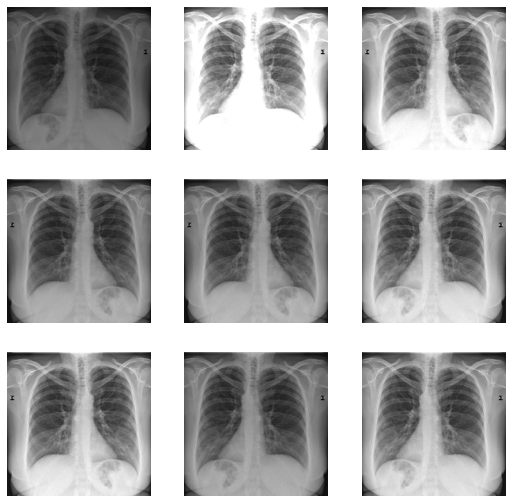

In [18]:
x = img_to_array(keras.preprocessing.image.array_to_img(xtrain[30]))
x2 = x.reshape((1,) + x.shape)
i = 0
fig = plt.figure(figsize = (9,9))
plt.title('Pre-processed')
for batch in train_datagen.flow(x2, batch_size = 1):
    i += 1
    if i > 9:
        break
    temp = batch.reshape(x.shape)
    plt.subplot(3, 3, i)
    plt.imshow(temp.astype('uint8'))
    plt.axis('off')
plt.show()

# Fit the model

In [0]:
#Membuat EarlyStopping
es = EarlyStopping(
                    monitor='val_accuracy', 
                    mode='max',
                    patience=10
                  )

In [20]:
#fit the model 
history = model.fit(train_generator,
                    validation_data=(xtest,ytest), 
                    epochs=30,
                    callbacks=[es]
                    )    

Epoch 1/30
11/11 [==============================] - 96s 9s/step - loss: 0.3598 - accuracy: 0.9043 - val_loss: 3.4947 - val_accuracy: 0.6835
Epoch 2/30
11/11 [==============================] - 88s 8s/step - loss: 0.0906 - accuracy: 0.9907 - val_loss: 1.5014 - val_accuracy: 0.8705
Epoch 3/30
11/11 [==============================] - 87s 8s/step - loss: 0.0279 - accuracy: 0.9877 - val_loss: 3.6610 - val_accuracy: 0.6835
Epoch 4/30
11/11 [==============================] - 88s 8s/step - loss: 6.4586e-04 - accuracy: 1.0000 - val_loss: 1.8484 - val_accuracy: 0.8129
Epoch 6/30
11/11 [==============================] - 88s 8s/step - loss: 4.6537e-06 - accuracy: 1.0000 - val_loss: 1.6601 - val_accuracy: 0.8345
Epoch 7/30
11/11 [==============================] - 89s 8s/step - loss: 2.7033e-06 - accuracy: 1.0000 - val_loss: 1.6241 - val_accuracy: 0.8345
Epoch 8/30
11/11 [==============================] - 91s 8s/step - loss: 0.0336 - accuracy: 0.9969 - val_loss: 2.5407 - val_accuracy: 0.7842
Epoch 9/

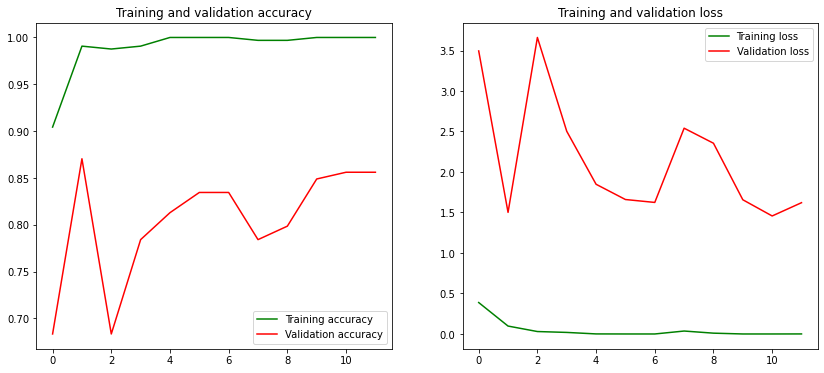

In [21]:
def plot_accuracy_and_loss(history):
    hist = history.history
    acc = hist['accuracy']
    val_acc = hist['val_accuracy']
    loss = hist['loss']
    val_loss = hist['val_loss']
    epochs = range(len(acc))
    f, ax = plt.subplots(1,2, figsize=(14,6))
    ax[0].plot(epochs, acc, 'g', label='Training accuracy')
    ax[0].plot(epochs, val_acc, 'r', label='Validation accuracy')
    ax[0].set_title('Training and validation accuracy')
    ax[0].legend()
    ax[1].plot(epochs, loss, 'g', label='Training loss')
    ax[1].plot(epochs, val_loss, 'r', label='Validation loss')
    ax[1].set_title('Training and validation loss')
    ax[1].legend()
    plt.show()
plot_accuracy_and_loss(history)


In [22]:
train_loss, train_acc = model.evaluate(xtrain,  ytrain, verbose=2)
test_loss, test_acc = model.evaluate(xtest,  ytest, verbose=2)
print("Training accuracy= ", train_acc)
print("Validation accuracy= ", test_acc)

Training accuracy=  0.8858024477958679
Validation accuracy=  0.8561151027679443


# Confusion Matrix

In [0]:
from sklearn.metrics import confusion_matrix
pred = model.predict(xtest)
pred = np.argmax(pred,axis = 1) 
y_true = np.argmax(ytest,axis = 1)

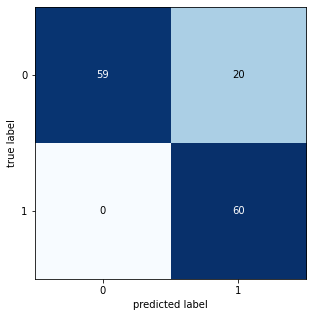

In [24]:
CM = confusion_matrix(y_true, pred)
from mlxtend.plotting import plot_confusion_matrix

fig, ax = plot_confusion_matrix(conf_mat=CM ,  figsize=(5, 5))
plt.show()

In [25]:
from sklearn import metrics
# Print the precision and recall, among other metrics
print(metrics.classification_report(y_true, pred, digits=2,  target_names = ['covid19', 'normal']))

              precision    recall  f1-score   support

     covid19       1.00      0.75      0.86        79
      normal       0.75      1.00      0.86        60

    accuracy                           0.86       139
   macro avg       0.88      0.87      0.86       139
weighted avg       0.89      0.86      0.86       139



In [41]:
model_feat = Model(inputs=model.input,outputs=model.get_layer

('dense_1').output)

feat_train = model_feat.predict(xtrain)
print(feat_train.shape)


feat_test = model_feat.predict(xtest)
print(feat_test.shape)

(324, 2)
(139, 2)


# Applying LGBMClassifier

In [51]:
import lightgbm as lgb
from lightgbm import LGBMClassifier

lgbc = lgb.LGBMClassifier()

lgbc.fit(feat_train,np.argmax(ytrain,axis=1))

print('fitting done !!!')

fitting done !!!


Prediction Score [Training Features]

In [52]:
lgbc.score(feat_train,np.argmax(ytrain,axis=1))

0.9969135802469136

Prediction Score [Validation Features]

In [53]:
lgbc.score(feat_test,np.argmax(ytest,axis=1))

0.9928057553956835

In [0]:
Predlgb = lgbc.predict(feat_test)

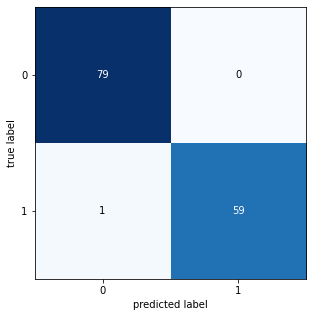

In [57]:
CM = confusion_matrix(y_true, Predlgb)
from mlxtend.plotting import plot_confusion_matrix

fig, ax = plot_confusion_matrix(conf_mat=CM ,  figsize=(5, 5))
plt.show()

In [59]:
from sklearn import metrics
# Print the precision and recall, among other metrics
print(metrics.classification_report(y_true, Predlgb, digits=2,  target_names = ['covid19', 'normal']))

              precision    recall  f1-score   support

     covid19       0.99      1.00      0.99        79
      normal       1.00      0.98      0.99        60

    accuracy                           0.99       139
   macro avg       0.99      0.99      0.99       139
weighted avg       0.99      0.99      0.99       139



In [33]:
# save model and architecture to single file
model.save("ariefbros.h5")
print("Saved model to disk")

Saved model to disk


In [0]:
import pickle
# save model to file
pickle.dump(model, open("ariefbros.pkl", "wb"))